In [1]:
import pandas as pd
import pandas_datareader.data as web
import pandas_datareader.famafrench as ff
import datetime
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import LSTM, Dense, Reshape
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
np.set_printoptions(linewidth=160)
pd.set_option('display.max_columns', None)

In [3]:
start = datetime.datetime(1998, 1, 1)
end = datetime.datetime(2021, 1, 1)

tickers = pd.read_csv("DJIA.csv", header=None) # components as of 2021-03-09
tickers = list(tickers[0])
for ticker in tickers:
    print(ticker)

MMM
AXP
AMGN
AAPL
BA
CAT
CVX
CSCO
KO
DOW
GS
HD
HON
IBM
INTC
JNJ
JPM
MCD
MRK
MSFT
NKE
PG
CRM
TRV
UNH
VZ
V
WBA
WMT
DIS


In [133]:
ff.get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

In [140]:
ff_dict = web.DataReader('North_America_5_Factors_Daily', "famafrench", start, end)
print(ff_dict.pop("DESCR"))
ff_dict = ff_dict[0]

North America 5 Factors Daily
-----------------------------

This file was created using the 202012 Bloomberg database. Missing data are indicated by -99.99. 

  0 : (6001 rows x 6 cols)


In [141]:
factors = pd.DataFrame(ff_dict)
factors.index = pd.to_datetime(factors.index.to_timestamp())
factors

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1998-01-01,-0.02,0.00,0.00,0.00,0.00,0.02
1998-01-02,0.23,-0.08,-0.54,0.15,-0.19,0.02
1998-01-05,0.24,-0.03,-0.39,0.11,0.01,0.02
1998-01-06,-1.09,0.25,0.01,-0.21,0.09,0.02
1998-01-07,-0.37,-0.27,-0.19,0.22,0.35,0.02
...,...,...,...,...,...,...
2020-12-25,0.00,0.00,0.00,0.00,0.00,0.00
2020-12-28,0.50,-0.86,0.34,1.05,0.39,0.00
2020-12-29,-0.36,-1.17,0.29,0.54,0.12,0.00


In [142]:
mom_dict = web.DataReader('North_America_MOM_Factor_Daily', "famafrench", start, end)
print(mom_dict.pop("DESCR"))
mom_dict = mom_dict[0]
mom_factors = pd.DataFrame(mom_dict)
mom_factors.index = pd.to_datetime(mom_factors.index.to_timestamp())
mom_factors

North America MOM Factor Daily
------------------------------

This file was created using the 202012 Bloomberg database. Missing data are indicated by -99.99. 

  0 : (6001 rows x 1 cols)


,WML
Date,
1998-01-01,0.00
1998-01-02,-1.16
1998-01-05,0.14
1998-01-06,0.07
1998-01-07,-0.45
...,...
2020-12-25,0.00
2020-12-28,-0.76
2020-12-29,-0.41


In [143]:
DJIA_raw = web.DataReader(tickers[:], 'yahoo', start, end)
DJIA_raw

Attributes   Adj Close                                                  \
Symbols            MMM         AXP        AMGN        AAPL          BA   
Date                                                                     
1998-01-02   23.195230   19.040146   10.670461    0.124974   30.740919   
1998-01-05   23.160500   19.080399   10.633366    0.122091   30.583677   
1998-01-06   23.229958   18.691282   10.509720    0.145644   30.111950   
1998-01-07   23.420925   18.516855   10.522089    0.134588   30.269196   
1998-01-08   23.143145   18.141138   10.559179    0.139875   29.168503   
...                ...         ...         ...         ...         ...   
2020-12-24  173.093628  116.939957  221.284622  131.773087  217.149994   
2020-12-28  173.282074  117.946426  221.999313  136.486053  216.089996   
2020-12-29  172.429108  117.727196  225.195541  134.668762  216.250000   
2020-12-30  172.686966  119.012688  225.493332  133.520477  216.669998   
2020-12-31  173.361404  120.487518  228.223038  132.492020  214.059998   

Attributes                                                          \
Symbols            CAT        CVX       CSCO         KO        DOW   
Date                                                                 
1998-01-02   13.254756  17.031889   7.236827  18.441542        NaN   
1998-01-05   13.440728  16.540184   7.221252  18.303787        NaN   
1998-01-06   13.339283  16.116776   7.127772  18.217699        NaN   
1998-01-07   13.102592  16.690437   6.917445  18.234917        NaN   
1998-01-08   12.663025  16.062149   6.995344  18.355444        NaN   
...                ...        ...        ...        ...        ...   
2020-12-24  178.609695  84.140633  44.181690  53.439999  54.187817   
2020-12-28  177.425995  83.716629  44.558628  54.160000  53.693314   
2020-12-29  175.715103  83.430672  44.280884  54.130001  53.732876   
2020-12-30  179.087158  84.140633  44.122169  54.439999  54.860344   
2020-12-31  181.056686  83.272896  44.389999  54.840000  54.890015   

Attributes                                                             \
Symbols             GS          HD         HON         IBM       INTC   
Date                                                                    
1998-01-02         NaN   12.742049   22.552612   32.795517  11.302661   
1998-01-05         NaN   12.565076   22.267132   33.047802  11.594467   
1998-01-06         NaN   12.646763   22.374182   32.679089  11.380476   
1998-01-07         NaN   12.782888   22.267132   32.368587  11.322114   
1998-01-08         NaN   12.728442   21.981657   32.349190  11.565288   
...                ...         ...         ...         ...        ...   
2020-12-24  255.157745  270.920013  208.606613  123.045761  46.786011   
2020-12-28  258.574310  269.250000  209.014816  123.174042  46.786011   
2020-12-29  257.000519  266.190002  208.208389  122.167496  49.092014   
2020-12-30  258.434875  265.260010  210.020355  122.700371  48.455875   
2020-12-31  262.678192  265.619995  211.762650  124.220062  49.519421   

Attributes                                                             \
Symbols            JNJ         JPM         MCD        MRK        MSFT   
Date                                                                    
1998-01-02   18.463949   18.983402   13.943696  23.896809   10.410520   
1998-01-05   18.446209   19.294432   13.907093  24.035593   10.350970   
1998-01-06   18.162428   18.393530   13.943696  23.702536   10.410520   
1998-01-07   18.339787   18.597303   13.833900  23.341717   10.286464   
1998-01-08   18.552624   17.878723   13.577722  23.577644   10.360898   
...                ...         ...         ...        ...         ...   
2020-12-24  151.525131  123.629646  210.097305  80.139999  222.238144   
2020-12-28  152.240677  124.443787  212.711227  80.449997  224.443069   
2020-12-29  153.184784  124.116150  211.409241  81.419998  223.634918   
2020-12-30  155.082947  124.463646  210.266266  80.589996  221.170593   
2020-12-31

In [144]:
# Select features
DJIA = DJIA_raw.copy()
DJIA = DJIA[["Adj Close", "Volume"]]

In [145]:
# Convert into returns
DJIA["Adj Close"] = DJIA["Adj Close"]/DJIA["Adj Close"].shift(1)
DJIA["Adj Close"] = DJIA["Adj Close"] - 1

In [146]:
# Scale volume so that first volume for that stock is 1
for column in DJIA["Volume"]:
    DJIA["Volume", column] = DJIA["Volume", column] / DJIA["Volume", column].loc[DJIA["Volume", column].first_valid_index()]

In [147]:
# Convert to rolling average
DJIA["Volume"] = DJIA["Volume"].rolling(7).sum()

In [148]:
# Shift to get rid of NaN
DJIA = DJIA.iloc[6:]

In [149]:
DJIA["MEAN"] = DJIA["Adj Close"].mean(axis=1)
DJIA

Attributes Adj Close                                                    \
Symbols          MMM       AXP      AMGN      AAPL        BA       CAT   
Date                                                                     
1998-01-12  0.002269 -0.003049  0.005938  0.003436  0.005540  0.022009   
1998-01-13  0.015850  0.012997 -0.018890  0.068495 -0.006886 -0.008076   
1998-01-14 -0.000744  0.006792 -0.037305  0.012820  0.026352  0.006784   
1998-01-15 -0.018587 -0.023988 -0.020000 -0.028479 -0.045946 -0.013550   
1998-01-16  0.009091  0.007680  0.000000 -0.019543 -0.015581 -0.004121   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.003046  0.003420 -0.000045  0.007712 -0.011562  0.006389   
2020-12-28  0.001089  0.008607  0.003230  0.035766 -0.004881 -0.006627   
2020-12-29 -0.004922 -0.001859  0.014397 -0.013315  0.000740 -0.009643   
2020-12-30  0.001495  0.010919  0.001322 -0.008527  0.001942  0.019190   
2020-12-31  0.003906  0.012392  0.012105 -0.007703 -0.012046  0.010998   

Attributes                                                              \
Symbols          CVX      CSCO        KO       DOW        GS        HD   
Date                                                                     
1998-01-12  0.030756  0.026497  0.030215       NaN       NaN  0.031042   
1998-01-13  0.017903  0.005612 -0.010407       NaN       NaN  0.017205   
1998-01-14  0.011725  0.017857 -0.011473       NaN       NaN  0.009514   
1998-01-15  0.007450  0.007676 -0.013540       NaN       NaN -0.006283   
1998-01-16  0.009038  0.007617  0.019608       NaN       NaN  0.000000   
...              ...       ...       ...       ...       ...       ...   
2020-12-24 -0.004201  0.003605  0.006782  0.000731 -0.001131  0.004114   
2020-12-28 -0.005039  0.008532  0.013473 -0.009126  0.013390 -0.006164   
2020-12-29 -0.003416 -0.006233 -0.000554  0.000737 -0.006086 -0.011365   
2020-12-30  0.008510 -0.003584  0.005727  0.020983  0.005581 -0.003494   
2020-12-31 -0.010313  0.006070  0.007348  0.000541  0.016419  0.001357   

Attributes                                                              \
Symbols          HON       IBM      INTC       JNJ       JPM       MCD   
Date                                                                     
1998-01-12 -0.025210  0.000625  0.052174  0.020310  0.007362  0.022039   
1998-01-13  0.013794  0.019975  0.017355  0.006634  0.009744  0.016172   
1998-01-14  0.030612  0.004896 -0.019496  0.001884  0.007238 -0.001326   
1998-01-15 -0.033004  0.007917 -0.001657 -0.012219 -0.010778 -0.005312   
1998-01-16 -0.008533  0.015107 -0.006639  0.031399  0.021792  0.016021   
...              ...       ...       ...       ...       ...       ...   
2020-12-24 -0.002191  0.006376  0.010737  0.003488 -0.004398 -0.002971   
2020-12-28  0.001957  0.001043  0.000000  0.004722  0.006585  0.012441   
2020-12-29 -0.003858 -0.008172  0.049288  0.006201 -0.002633 -0.006121   
2020-12-30  0.008703  0.004362 -0.012958  0.012391  0.002800 -0.005406   
2020-12-31  0.008296  0.012385  0.021949  0.008523  0.013641  0.014275   

Attributes                                                              \
Symbols          MRK      MSFT       NKE        PG       CRM       TRV   
Date                                                                     
1998-01-12  0.032200  0.019685  0.011076  0.043582       NaN  0.024773   
1998-01-13  0.000588  0.020270  0.025040 -0.014427       NaN  0.008864   
1998-01-14  0.034118 -0.007568  0.006106 -0.006934       NaN -0.003994   
1998-01-15 -0.010808  0.009056  0.004553 -0.007758       NaN  0.000802   
1998-01-16  0.009775  0.022202 -0.004532 -0.007818       NaN  0.001602   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.004764  0.007827 -0.001129  0.010122 -0.007255  0.003915   
2020-12-28  0.003868  0.009921  0.005861  0.006971 -0.005049  0.005054   
2020-12-29  0.012057 -0.003601 -0.006038 -0.001875 -0.009704 -0.006035   
2

In [150]:
# Merge stocks with factors
DJIA.columns = DJIA.columns.get_level_values(0)
DJIA = DJIA.join(factors)
DJIA = DJIA.join(mom_factors)
DJIA

,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,MEAN,Mkt-RF,SMB,HML,RMW,CMA,RF,WML
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-01-12,0.002269,-0.003049,0.005938,0.003436,0.005540,0.022009,0.030756,0.026497,0.030215,NaN,NaN,0.031042,-0.025210,0.000625,0.052174,0.020310,0.007362,0.022039,0.032200,0.019685,0.011076,0.043582,NaN,0.024773,-0.017677,0.018050,NaN,0.035270,0.034369,-0.016276,9.197590,9.037432,11.601115,8.913736,10.634375,12.457398,10.170651,11.212117,8.801146,NaN,NaN,8.954002,10.815496,12.587742,12.473289,8.469633,21.150633,9.287277,8.820043,12.403140,10.257742,9.280339,NaN,20.793443,13.543268,7.024380,NaN,8.391171,11.842238,12.826648,0.016039,0.69,-1.69,-0.32,0.85,0.61,0.02,0.22
1998-01-13,0.015850,0.012997,-0.018890,0.068495,-0.006886,-0.008076,0.017903,0.005612,-0.010407,NaN,NaN,0.017205,0.013794,0.019975,0.017355,0.006634,0.009744,0.016172,0.000588,0.020270,0.025040,-0.014427,NaN,0.008864,-0.012854,0.013475,NaN,0.002004,0.000000,0.005956,8.834979,8.978229,13.014830,8.800583,10.982544,14.247732,10.210113,11.667278,8.976925,NaN,NaN,9.383114,11.231385,12.883567,13.851854,8.821450,22.564770,9.519382,9.180307,13.087391,9.962624,9.684173,NaN,22.454098,14.620737,6.756703,NaN,9.805862,12.492970,13.536464,0.008707,1.47,0.07,-0.62,-0.50,-0.99,0.02,-0.09
1998-01-14,-0.000744,0.006792,-0.037305,0.012820,0.026352,0.006784,0.011725,0.017857,-0.011473,NaN,NaN,0.009514,0.030612,0.004896,-0.019496,0.001884,0.007238,-0.001326,0.034118,-0.007568,0.006106,-0.006934,NaN,-0.003994,0.018229,0.000000,NaN,0.030000,0.004747,0.015789,8.566498,8.685993,15.203835,8.713399,10.831275,14.907658,9.530198,11.234028,8.606114,NaN,NaN,9.224400,10.848166,12.602125,14.965871,8.752470,23.507665,8.824574,10.096890,12.443252,9.025853,9.340888,NaN,23.113115,14.317366,6.312705,NaN,9.902117,13.075022,10.681505,0.006024,0.61,0.03,0.28,-0.05,-0.03,0.02,0.48
1998-01-15,-0.018587,-0.023988,-0.020000,-0.028479,-0.045946,-0.013550,0.007450,0.007676,-0.013540,NaN,NaN,-0.006283,-0.033004,0.007917,-0.001657,-0.012219,-0.010778,-0.005312,-0.010808,0.009056,0.004553,-0.007758,NaN,0.000802,-0.038363,-0.003499,NaN,-0.021359,0.006299,-0.008419,7.668636,8.515939,17.036743,6.968261,11.323145,15.761041,8.232037,11.135027,8.370701,NaN,NaN,9.189752,11.168224,13.651879,15.091577,8.643330,22.058957,8.615299,10.430296,12.010224,8.053723,8.908820,NaN,23.867213,15.566726,5.591526,NaN,10.187986,12.390069,10.253153,-0.010761,-0.61,0.61,0.08,-0.13,-0.11,0.02,-0.10
1998-01-16,0.009091,0.007680,0.000000,-0.019543,-0.015581,-0.004121,0.009038,0.007617,0.019608,NaN,NaN,0.000000,-0.008533,0.015107,-0.006639,0.031399,0.021792,0.016021,0.009775,0.022202,-0.004532,-0.007818,NaN,0.001602,0.023936,0.001404,NaN,0.029762,0.004695,0.004572,7.681150,8.481506,17.332011,5.860817,14.370659,17.342454,7.885431,10.537572,8.896091,NaN,NaN,8.677586,10.981023,13.606679,15.186878,9.410918,20.605001,8.943163,10.734789,12.298299,7.002881,9.199586,NaN,23.326230,15.661739,5.277916,NaN,11.024606,13.026443,10.258795,0.006482,1.09,-0.14,-0.18,0.02,-0.30,0.02,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.003046,0.003420,-0.000045,0.007712,-0.011562,0.006389,-0.004201,0.003605,0.006782,0.000731,-0.001131,0.004114,-0.002191,0.006376,0.010737,0.003488,-0.004398,-0.002971,0.004764,0.007827

In [151]:
DJIA["ER"] = DJIA["MEAN"] - DJIA["RF"]/253 # daily rf
DJIA["ER_t+1"] = DJIA["ER"].shift(-1)
DJIA = DJIA.iloc[:-1]
DJIA

,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,MEAN,Mkt-RF,SMB,HML,RMW,CMA,RF,WML,ER,ER_t+1
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-01-12,0.002269,-0.003049,0.005938,0.003436,0.005540,0.022009,0.030756,0.026497,0.030215,NaN,NaN,0.031042,-0.025210,0.000625,0.052174,0.020310,0.007362,0.022039,0.032200,0.019685,0.011076,0.043582,NaN,0.024773,-0.017677,0.018050,NaN,0.035270,0.034369,-0.016276,9.197590,9.037432,11.601115,8.913736,10.634375,12.457398,10.170651,11.212117,8.801146,NaN,NaN,8.954002,10.815496,12.587742,12.473289,8.469633,21.150633,9.287277,8.820043,12.403140,10.257742,9.280339,NaN,20.793443,13.543268,7.024380,NaN,8.391171,11.842238,12.826648,0.016039,0.69,-1.69,-0.32,0.85,0.61,0.02,0.22,0.015960,0.008628
1998-01-13,0.015850,0.012997,-0.018890,0.068495,-0.006886,-0.008076,0.017903,0.005612,-0.010407,NaN,NaN,0.017205,0.013794,0.019975,0.017355,0.006634,0.009744,0.016172,0.000588,0.020270,0.025040,-0.014427,NaN,0.008864,-0.012854,0.013475,NaN,0.002004,0.000000,0.005956,8.834979,8.978229,13.014830,8.800583,10.982544,14.247732,10.210113,11.667278,8.976925,NaN,NaN,9.383114,11.231385,12.883567,13.851854,8.821450,22.564770,9.519382,9.180307,13.087391,9.962624,9.684173,NaN,22.454098,14.620737,6.756703,NaN,9.805862,12.492970,13.536464,0.008707,1.47,0.07,-0.62,-0.50,-0.99,0.02,-0.09,0.008628,0.005945
1998-01-14,-0.000744,0.006792,-0.037305,0.012820,0.026352,0.006784,0.011725,0.017857,-0.011473,NaN,NaN,0.009514,0.030612,0.004896,-0.019496,0.001884,0.007238,-0.001326,0.034118,-0.007568,0.006106,-0.006934,NaN,-0.003994,0.018229,0.000000,NaN,0.030000,0.004747,0.015789,8.566498,8.685993,15.203835,8.713399,10.831275,14.907658,9.530198,11.234028,8.606114,NaN,NaN,9.224400,10.848166,12.602125,14.965871,8.752470,23.507665,8.824574,10.096890,12.443252,9.025853,9.340888,NaN,23.113115,14.317366,6.312705,NaN,9.902117,13.075022,10.681505,0.006024,0.61,0.03,0.28,-0.05,-0.03,0.02,0.48,0.005945,-0.010840
1998-01-15,-0.018587,-0.023988,-0.020000,-0.028479,-0.045946,-0.013550,0.007450,0.007676,-0.013540,NaN,NaN,-0.006283,-0.033004,0.007917,-0.001657,-0.012219,-0.010778,-0.005312,-0.010808,0.009056,0.004553,-0.007758,NaN,0.000802,-0.038363,-0.003499,NaN,-0.021359,0.006299,-0.008419,7.668636,8.515939,17.036743,6.968261,11.323145,15.761041,8.232037,11.135027,8.370701,NaN,NaN,9.189752,11.168224,13.651879,15.091577,8.643330,22.058957,8.615299,10.430296,12.010224,8.053723,8.908820,NaN,23.867213,15.566726,5.591526,NaN,10.187986,12.390069,10.253153,-0.010761,-0.61,0.61,0.08,-0.13,-0.11,0.02,-0.10,-0.010840,0.006403
1998-01-16,0.009091,0.007680,0.000000,-0.019543,-0.015581,-0.004121,0.009038,0.007617,0.019608,NaN,NaN,0.000000,-0.008533,0.015107,-0.006639,0.031399,0.021792,0.016021,0.009775,0.022202,-0.004532,-0.007818,NaN,0.001602,0.023936,0.001404,NaN,0.029762,0.004695,0.004572,7.681150,8.481506,17.332011,5.860817,14.370659,17.342454,7.885431,10.537572,8.896091,NaN,NaN,8.677586,10.981023,13.606679,15.186878,9.410918,20.605001,8.943163,10.734789,12.298299,7.002881,9.199586,NaN,23.326230,15.661739,5.277916,NaN,11.024606,13.026443,10.258795,0.006482,1.09,-0.14,-0.18,0.02,-0.30,0.02,0.04,0.006403,0.019612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,-0.004520,0.020952,0.008824,-0.006976,0.004159,0.010420,0.015766,-0.006937

In [152]:
DJIA.replace(-99.99, np.nan, inplace=True) # For FF
DJIA.isnull().sum()
DJIA.fillna(0, inplace=True)
DJIA

/home/benja/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
/home/benja/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,MEAN,Mkt-RF,SMB,HML,RMW,CMA,RF,WML,ER,ER_t+1
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-01-12,0.002269,-0.003049,0.005938,0.003436,0.005540,0.022009,0.030756,0.026497,0.030215,0.000000,0.000000,0.031042,-0.025210,0.000625,0.052174,0.020310,0.007362,0.022039,0.032200,0.019685,0.011076,0.043582,0.000000,0.024773,-0.017677,0.018050,0.000000,0.035270,0.034369,-0.016276,9.197590,9.037432,11.601115,8.913736,10.634375,12.457398,10.170651,11.212117,8.801146,0.000000,0.000000,8.954002,10.815496,12.587742,12.473289,8.469633,21.150633,9.287277,8.820043,12.403140,10.257742,9.280339,0.000000,20.793443,13.543268,7.024380,0.000000,8.391171,11.842238,12.826648,0.016039,0.69,-1.69,-0.32,0.85,0.61,0.02,0.22,0.015960,0.008628
1998-01-13,0.015850,0.012997,-0.018890,0.068495,-0.006886,-0.008076,0.017903,0.005612,-0.010407,0.000000,0.000000,0.017205,0.013794,0.019975,0.017355,0.006634,0.009744,0.016172,0.000588,0.020270,0.025040,-0.014427,0.000000,0.008864,-0.012854,0.013475,0.000000,0.002004,0.000000,0.005956,8.834979,8.978229,13.014830,8.800583,10.982544,14.247732,10.210113,11.667278,8.976925,0.000000,0.000000,9.383114,11.231385,12.883567,13.851854,8.821450,22.564770,9.519382,9.180307,13.087391,9.962624,9.684173,0.000000,22.454098,14.620737,6.756703,0.000000,9.805862,12.492970,13.536464,0.008707,1.47,0.07,-0.62,-0.50,-0.99,0.02,-0.09,0.008628,0.005945
1998-01-14,-0.000744,0.006792,-0.037305,0.012820,0.026352,0.006784,0.011725,0.017857,-0.011473,0.000000,0.000000,0.009514,0.030612,0.004896,-0.019496,0.001884,0.007238,-0.001326,0.034118,-0.007568,0.006106,-0.006934,0.000000,-0.003994,0.018229,0.000000,0.000000,0.030000,0.004747,0.015789,8.566498,8.685993,15.203835,8.713399,10.831275,14.907658,9.530198,11.234028,8.606114,0.000000,0.000000,9.224400,10.848166,12.602125,14.965871,8.752470,23.507665,8.824574,10.096890,12.443252,9.025853,9.340888,0.000000,23.113115,14.317366,6.312705,0.000000,9.902117,13.075022,10.681505,0.006024,0.61,0.03,0.28,-0.05,-0.03,0.02,0.48,0.005945,-0.010840
1998-01-15,-0.018587,-0.023988,-0.020000,-0.028479,-0.045946,-0.013550,0.007450,0.007676,-0.013540,0.000000,0.000000,-0.006283,-0.033004,0.007917,-0.001657,-0.012219,-0.010778,-0.005312,-0.010808,0.009056,0.004553,-0.007758,0.000000,0.000802,-0.038363,-0.003499,0.000000,-0.021359,0.006299,-0.008419,7.668636,8.515939,17.036743,6.968261,11.323145,15.761041,8.232037,11.135027,8.370701,0.000000,0.000000,9.189752,11.168224,13.651879,15.091577,8.643330,22.058957,8.615299,10.430296,12.010224,8.053723,8.908820,0.000000,23.867213,15.566726,5.591526,0.000000,10.187986,12.390069,10.253153,-0.010761,-0.61,0.61,0.08,-0.13,-0.11,0.02,-0.10,-0.010840,0.006403
1998-01-16,0.009091,0.007680,0.000000,-0.019543,-0.015581,-0.004121,0.009038,0.007617,0.019608,0.000000,0.000000,0.000000,-0.008533,0.015107,-0.006639,0.031399,0.021792,0.016021,0.009775,0.022202,-0.004532,-0.007818,0.000000,0.001602,0.023936,0.001404,0.000000,0.029762,0.004695,0.004572,7.681150,8.481506,17.332011,5.860817,14.370659,17.342454,7.885431,10.537572,8.896091,0.000000,0.000000,8.677586,10.981023,13.606679,15.186878,9.410918,20.605001,8.943163,10.734789,12.298299,7.002881,9.199586,0.000000,23.326230,15.661739,5.277916,0.000000,11.024606,13.026443,10.258795,0.006482,1.09,-0.14,-0.18,0.02,-0.30,0.02,0.04,0.006403,0.019612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [153]:
data = DJIA.to_numpy()
data[99:102]

array([[ 1.36232152e-02,  1.21730400e-02,  7.09963227e-03,  1.90009360e-02, -1.77107144e-02,  1.37453478e-02,  1.50433097e-02,  3.01505018e-02,
         9.44088227e-03,  0.00000000e+00,  0.00000000e+00,  4.05752121e-03, -1.02635791e-02,  1.92101386e-02,  3.41237553e-02,  2.39847144e-02,
         1.38250655e-02,  1.51802337e-02,  2.77628283e-02,  2.07565706e-02,  6.83084786e-03,  7.28283468e-03,  0.00000000e+00,  8.45077241e-03,
        -4.00009172e-03,  0.00000000e+00,  0.00000000e+00,  2.52524520e-02,  1.11605065e-02,  0.00000000e+00,  3.63738826e+00,  7.95112722e+00,
         1.37656560e+01,  2.34738057e+00,  1.04346503e+01,  9.29026022e+00,  6.29214993e+00,  9.13065819e+00,  6.71351411e+00,  0.00000000e+00,
         0.00000000e+00,  1.96827444e+01,  1.26735129e+01,  9.24705882e+00,  1.35878438e+01,  6.20608195e+00,  1.11859245e+01,  9.54205311e+00,
         6.76453348e+00,  6.89716212e+00,  3.59441164e+00,  8.10419635e+00,  0.00000000e+00,  3.30073770e+01,  3.29767396e+01,  4.081287

In [18]:
#scaler = MinMaxScaler((-1, 1))
#data = scaler.fit_transform(data)
#data, data.shape

In [154]:
X = []
Y = []
input_period = 100
output_period = 21
for i in range(input_period, data.shape[0]-output_period+1):
    X.append(data[(i-input_period):i, :-1])
    Y.append(data[i:(i+output_period), -1:]) # we predict mean return next period

X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)
print(Y[:2])

(5661, 100, 69)
(5661, 21, 1)
[[[ 0.00367379]
  [ 0.00459347]
  [-0.00519612]
  [-0.01168963]
  [ 0.00103185]
  [-0.01920356]
  [ 0.00765227]
  [ 0.01673232]
  [ 0.00264557]
  [-0.00587857]
  [ 0.00279991]
  [ 0.01462421]
  [ 0.01653728]
  [-0.00514313]
  [ 0.00647256]
  [ 0.00872472]
  [-0.00585644]
  [ 0.01668678]
  [-0.00314273]
  [ 0.01150549]
  [ 0.00037289]]

 [[ 0.00459347]
  [-0.00519612]
  [-0.01168963]
  [ 0.00103185]
  [-0.01920356]
  [ 0.00765227]
  [ 0.01673232]
  [ 0.00264557]
  [-0.00587857]
  [ 0.00279991]
  [ 0.01462421]
  [ 0.01653728]
  [-0.00514313]
  [ 0.00647256]
  [ 0.00872472]
  [-0.00585644]
  [ 0.01668678]
  [-0.00314273]
  [ 0.01150549]
  [ 0.00037289]
  [ 0.01030926]]]


In [155]:
# replace nan with mean of row
#X = X.T
#col_mean = np.nanmean(X, axis=0)
#inds = np.where(np.isnan(X))
#X[inds] = np.take(col_mean, inds[1])
#X = X.T
#X

In [156]:
split = 5000
trainX, trainY = X[:split, :], Y[:split, :]
valX, valY = X[split+output_period:, :], Y[split+output_period:, :] # + output_period so that they dont overlap

In [157]:
print(trainX.shape, trainY.shape)
print(valX.shape, valY.shape)

(5000, 100, 69) (5000, 21, 1)
(640, 100, 69) (640, 21, 1)


In [158]:
i = 7
valY[i:i+1, :7, 0]

array([[-0.00971516,  0.00990458,  0.00775093, -0.00160474,  0.01134836,  0.00293128,  0.00272487]])

Epoch 1/25
157/157 [==============================] - 23s 143ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 2/25
157/157 [==============================] - 29s 183ms/step - loss: 3.7700e-04 - mse: 3.7700e-04 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 3/25
157/157 [==============================] - 25s 160ms/step - loss: 2.5034e-04 - mse: 2.5034e-04 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 4/25
157/157 [==============================] - 23s 147ms/step - loss: 2.0883e-04 - mse: 2.0883e-04 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 5/25
157/157 [==============================] - 23s 149ms/step - loss: 2.0184e-04 - mse: 2.0184e-04 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 6/25
157/157 [==============================] - 22s 137ms/step - loss: 1.9135e-04 - mse: 1.9135e-04 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 7/25
157/157 [==============================] - 22s 142ms/step - loss: 1.7221e-04 - mse: 1.7221e-04 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 8

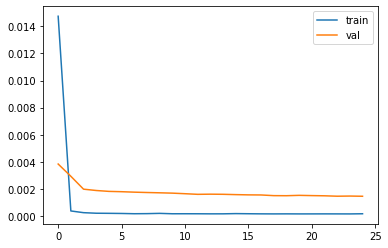

In [159]:
time_steps = trainX.shape[1]
features = trainX.shape[2]
pred_steps = output_period
pred_feat = 1

lstm_model = Sequential()

lstm_model.add(LSTM(100, return_sequences=False, input_shape=(time_steps, features)))
lstm_model.add(Dense(pred_steps*pred_feat))
lstm_model.add(Reshape([pred_steps, pred_feat]))

lstm_model.compile(loss="mse", optimizer="adam", metrics=["mse"]) # mae vs mse?

history = lstm_model.fit(trainX, trainY, epochs=25, validation_data=(valX, valY))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [160]:
def to_cumu(y):
    y[0] += 1
    for i in range(1, len(y)):
        y[i] = (y[i]+1) * y[i-1]
    for i in range(len(y)):
        y[i] -= 1
    return y
to_cumu([0.1, 0.1, -0.1]) # good

[0.10000000000000009, 0.2100000000000002, 0.08900000000000019]

In [161]:
def to_cumu_np(array):
    array = array.copy()
    c = []
    for a in array:
        c.append(to_cumu(a)[-1])
    return c

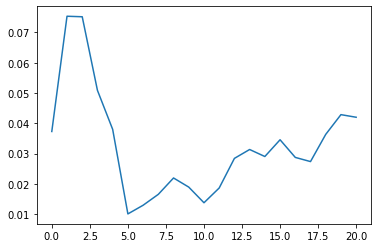

In [162]:
pred_val = lstm_model.predict(valX)
c = []
for i in range(output_period):
    c.append(np.corrcoef(to_cumu_np(pred_val[:, :i+1, 0]), to_cumu_np(valY[:, :i+1, 0]))[0][1])
plt.plot(c)

In [168]:
len(c)

21

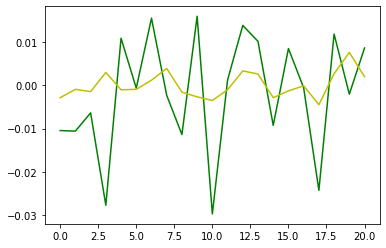

In [163]:
plt.plot(valY[300, : , 0], c="g")
plt.plot(pred_val[300, : , 0], c="y")

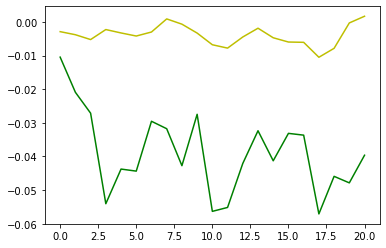

In [164]:
idx = 300
a = []
b = []
for i in range(output_period):
    a.append(to_cumu_np(valY[idx:idx+1, :i+1 , 0]))
    b.append(to_cumu_np(pred_val[idx:idx+1, :i+1 , 0]))
plt.plot(a, c="g")
plt.plot(b, c="y")

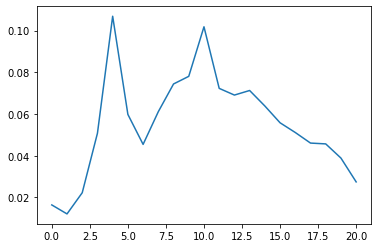

In [165]:
pred_train = lstm_model.predict(trainX)
ct = []
for i in range(output_period):
    ct.append(np.corrcoef(to_cumu_np(pred_train[:, :i+1, 0]), to_cumu_np(trainY[:, :i+1, 0]))[0][1])
plt.plot(ct)

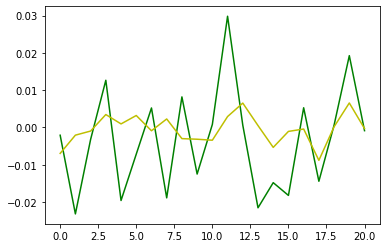

In [166]:
plt.plot(trainY[1000, : , 0], c="g")
plt.plot(pred_train[1000, : , 0], c="y")

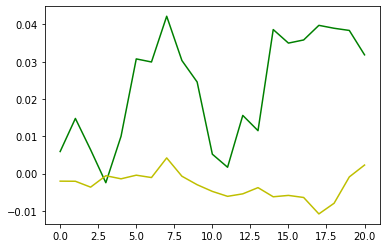

In [167]:
idx = 300
a = []
b = []
for i in range(output_period):
    a.append(to_cumu_np(trainY[idx:idx+1, :i+1 , 0]))
    b.append(to_cumu_np(pred_train[idx:idx+1, :i+1 , 0]))
plt.plot(a, c="g")
plt.plot(b, c="y")